In [8]:
import os, json, numpy as np, pandas as pd, matplotlib.pyplot as plt, torch
from pathlib import Path

# --- Verify current working directory ---
print("Current working directory:", Path.cwd())

# --- Locate the flattened CSV ---
# Your file lives in notebooks/data/processed/
DATA_DIR = Path("data/processed")
if not DATA_DIR.exists():
    raise FileNotFoundError(f"Data folder not found at {DATA_DIR.resolve()}")

# Find the first (or most recent) *_flattened.csv file
csv_files = list(DATA_DIR.glob("*_flattened.csv"))
if not csv_files:
    raise FileNotFoundError(
        f"No flattened CSV files found in {DATA_DIR.resolve()}\n"
        "Expected something like: Kepler-10_Kepler_flattened.csv"
    )

# Pick the most recent CSV file automatically
FLATTENED_CSV = max(csv_files, key=lambda f: f.stat().st_mtime)
print("Using flattened CSV:", FLATTENED_CSV.resolve())

# --- Locate the trained model directory (one level up) ---
MODEL_DIR = Path("../models/exopattern_cae_v1").resolve()
print("Looking for model files in:", MODEL_DIR)

# Define paths
WEIGHTS   = MODEL_DIR / "model.pt"
CFG_JSON  = MODEL_DIR / "config.json"

# --- Verify model files exist ---
assert WEIGHTS.exists(), f"❌ Missing model weights: {WEIGHTS}"
assert CFG_JSON.exists(), f"❌ Missing config file: {CFG_JSON}"

# --- Load config parameters ---
with open(CFG_JSON, "r") as f:
    cfg = json.load(f)

WIN = int(cfg.get("window_len", 2048))
STR = int(cfg.get("window_stride", 256))
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

print(f"\n✅ Configuration Loaded:")
print(f"Window length: {WIN}")
print(f"Window stride: {STR}")
print(f"Device: {DEVICE}")
print(f"CSV File: {FLATTENED_CSV.name}")
print(f"Model directory: {MODEL_DIR}")


Current working directory: c:\Users\arnav\Desktop\Arnav\ROG\Arnav\Arnav\python\ExoPatternNet\notebooks
Using flattened CSV: C:\Users\arnav\Desktop\Arnav\ROG\Arnav\Arnav\python\ExoPatternNet\notebooks\data\processed\Kepler-10_Kepler_flattened.csv
Looking for model files in: C:\Users\arnav\Desktop\Arnav\ROG\Arnav\Arnav\python\ExoPatternNet\models\exopattern_cae_v1

✅ Configuration Loaded:
Window length: 2048
Window stride: 256
Device: cpu
CSV File: Kepler-10_Kepler_flattened.csv
Model directory: C:\Users\arnav\Desktop\Arnav\ROG\Arnav\Arnav\python\ExoPatternNet\models\exopattern_cae_v1


In [9]:
df = pd.read_csv(FLATTENED_CSV)
# Expect at least columns: time, flux (already flattened/normalized around ~1)
# If your pipeline normalized to exactly ~1 median, good. If not, we normalize here lightly.
flux = df["flux"].to_numpy().astype(np.float32)

# Optional re-normalize to ~1.0 median just in case
med = np.nanmedian(flux)
if not np.isfinite(med) or med == 0:
    med = 1.0
flux_norm = (flux / med).astype(np.float32)
time_vals = df["time"].to_numpy() if "time" in df.columns else np.arange(len(flux_norm), dtype=np.float32)
print("Length:", len(flux_norm))


Length: 43337


In [10]:
import torch.nn as nn

class Conv1dBlock(nn.Sequential):
    def __init__(self, cin, cout, k=7, s=2, p=None):
        if p is None: p = k // 2
        super().__init__(
            nn.Conv1d(cin, cout, kernel_size=k, stride=s, padding=p, bias=False),
            nn.BatchNorm1d(cout),
            nn.ReLU(inplace=True)
        )

class Deconv1dBlock(nn.Sequential):
    def __init__(self, cin, cout, k=7, s=2, p=None, outpad=None):
        if p is None: p = k // 2
        if outpad is None: outpad = s - 1
        super().__init__(
            nn.ConvTranspose1d(cin, cout, kernel_size=k, stride=s, padding=p, output_padding=outpad, bias=False),
            nn.BatchNorm1d(cout),
            nn.ReLU(inplace=True)
        )

class CNNAutoencoder(nn.Module):
    def __init__(self, base=32):
        super().__init__()
        self.enc = nn.Sequential(
            Conv1dBlock(1, base, k=9, s=2),
            Conv1dBlock(base, base*2, k=7, s=2),
            Conv1dBlock(base*2, base*4, k=7, s=2),
            Conv1dBlock(base*4, base*4, k=5, s=2),
        )
        self.bottleneck = nn.Sequential(
            nn.Conv1d(base*4, base*4, kernel_size=3, padding=1, bias=False),
            nn.ReLU(inplace=True)
        )
        self.dec = nn.Sequential(
            Deconv1dBlock(base*4, base*4, k=5, s=2),
            Deconv1dBlock(base*4, base*2, k=7, s=2),
            Deconv1dBlock(base*2, base, k=7, s=2),
            nn.ConvTranspose1d(base, 1, kernel_size=9, stride=2, padding=4, output_padding=1)
        )
    def forward(self, x):
        z = self.enc(x)
        z = self.bottleneck(z)
        out = self.dec(z)
        return out



In [11]:
BASE = int(json.load(open(MODEL_DIR / "metrics.json")).get("base", 32)) if (MODEL_DIR / "metrics.json").exists() else 32

model = CNNAutoencoder(base=BASE).to(DEVICE)
state = torch.load(WEIGHTS, map_location=DEVICE)
model.load_state_dict(state, strict=True)
model.eval()
print("Model loaded. BASE:", BASE)


Model loaded. BASE: 32


In [12]:
def anomaly_score_series(series: np.ndarray, win=WIN, stride=STR, device=DEVICE, batch=64):
    T = len(series)
    scores = np.zeros(T, dtype=np.float32)
    counts = np.zeros(T, dtype=np.float32)

    # collect windows in small batches to speed up inference
    starts = list(range(0, max(1, T - win + 1), stride))
    for i in range(0, len(starts), batch):
        idxs = starts[i:i+batch]
        X = np.stack([series[s:s+win] for s in idxs], axis=0).astype(np.float32)   # (B, L)
        xb = torch.from_numpy(X[:, None, :]).to(device)                            # (B,1,L)
        with torch.no_grad():
            pred = model(xb).cpu().numpy()[:,0,:]                                  # (B,L)
        mse = ((pred - X) ** 2).astype(np.float32)                                  # (B,L)
        for j, s in enumerate(idxs):
            scores[s:s+win] += mse[j]
            counts[s:s+win] += 1.0
    counts[counts == 0] = 1.0
    return scores / counts

scores = anomaly_score_series(flux_norm, win=WIN, stride=STR, device=DEVICE, batch=64)
zscores = (scores - scores.mean()) / (scores.std() + 1e-8)
print("scores shape:", scores.shape, "zscores mean/std:", zscores.mean(), zscores.std())


scores shape: (43337,) zscores mean/std: 9.858691e-09 0.99999976


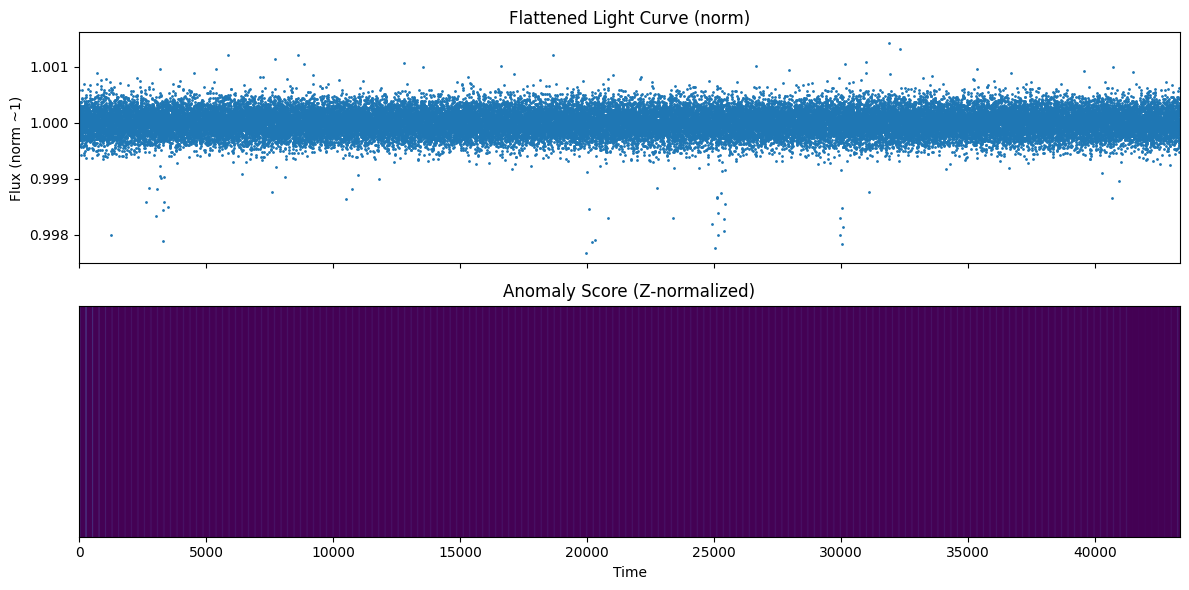

In [13]:
fig, ax = plt.subplots(2,1, figsize=(12,6), sharex=True)

ax[0].plot(time_vals, flux_norm, ".", ms=2)
ax[0].set_title("Flattened Light Curve (norm)")
ax[0].set_ylabel("Flux (norm ~1)")

ax[1].imshow(zscores[None, :], aspect="auto",
             extent=[time_vals[0], time_vals[-1], 0, 1])
ax[1].set_title("Anomaly Score (Z-normalized)")
ax[1].set_yticks([])
ax[1].set_xlabel("Time")

plt.tight_layout()
plt.show()
